In [164]:
import numpy as np
import nltk
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

## Read the dataset into memory

In [165]:
import os

def read_dataset(data_dir):
    for filename in os.listdir(data_dir):
        if not filename.startswith("issue_"):
            continue
        _, year, issue_id, article_id = filename.rpartition(".")[0].split("_")
        with open(os.path.join(data_dir, filename)) as f:
            full_text = f.read()
            title, _, abstract = full_text.partition("\n")
            yield (year, issue_id, article_id), title, abstract


In [166]:
dataset = list(read_dataset(".data/raw"))
raw_texts = [abstract for spec, title, abstract in dataset]


## The most basic pre-processing - remove special chars

In [167]:
all_texts = " ".join(raw_texts)
all_chars = set(all_texts)
print(sorted(all_chars))

[' ', '"', '$', '%', '&', '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '±', '²', '×', 'ä', 'é', 'ñ', 'ö', 'β', 'γ', 'η', 'κ', '–', '—', '’', '“', '”', '−', '∗', '∼', '≥']


In [168]:
char_replacements = {
    "±": "+",
    "ä": "a",
    'é': "e", 
    'ñ': "n", 
    'ö': "o", 
    '–': "-", 
    '—': "-", 
    '’': "'", 
    '“': "\"", 
    '”': "\"", 
    '−': "-", 
    '∗': "*", 
    '∼': "-", 
    '≥': ">",
    '²': '', 
    '×': "*",
}
# we do not replace greek letters because they are used for mathematical variables 
# which is important from semantic point of view

def do_replaces(text):
    for ch_from, ch_to in char_replacements.items():
        text = text.replace(ch_from, ch_to)
    return  text

raw_texts = list(map(do_replaces, raw_texts))

all_texts = " ".join(raw_texts)
all_chars = set(all_texts)
assert all(c.isascii() or c in "βγηκ" for c in all_chars)

## More complex preprocessing - tokenization and normalization

In [208]:
import string
stoptokens = {*nltk.corpus.stopwords.words("english"), *string.punctuation}

def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    return [t.lower() for t in tokens if t not in stoptokens]

texts = list(map(preprocess_text, raw_texts))

Most probably shortest tokens will contain all kinds of junk. Let's see what is going on here.

In [209]:
import itertools
all_tokens = set(itertools.chain(*texts))
all_tokens = sorted(all_tokens, key=lambda t: (len(t), t))
print(len(all_tokens), all_tokens[:50])

6414 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'e', 'g', 'i', 'k', 'm', 'n', 'p', 'r', 't', 'w', 'x', 'β', 'γ', 'η', 'κ', "''", "'s", '-9', '08', '1-', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1a', '1b', '20', '21', '22', '23', '24']


In [210]:
def find_usages(token, max_usages=None, texts_=None):
    if texts_ is None:
        texts_ = texts
    result = []
    for text_i, tokenseq in enumerate(texts_):
        for token_i, tok in enumerate(tokenseq):
            if tok == token:
                result.append((text_i, token_i))
                if max_usages is not None:
                    if len(result) >= max_usages:
                        return result
    return result

def print_usage_context(token, max_usages=None, texts_=None):
    if texts_ is None:
        texts_ = texts
    print(f"{token}:")
    for text_i, token_i in find_usages(token, max_usages):
        usage_ctx = texts_[text_i][max(0, token_i-3):token_i+4]
        print(f"   {text_i}:{token_i}: {usage_ctx}")

for token in [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'e', 'g', 
    'i', 'k', 'm', 'n', 'p', 'r', 't', 'w', 'x', 'β', 'γ', 'η', 'κ', "''", "'s", 
    '-9', '08', '1-', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 
    '1a', '1b', '20', '21', '22', '23', '24'
]:
    print_usage_context(token, 10)

0:
   56:41: ['also', 'refer', 'fractions', '0', '1', 'fractions', 'one']
   58:49: ['also', 'refer', 'fractions', '0', '1', 'fractions', 'one']
   282:80: ['uv', 'dosage', 'level', '0', '1', '2', '3']
   342:74: ['2', 'students', 'accurate', '0', 'immediately', 'followed', 'decimal']
1:
   4:69: ['multilevel', 'models', 'showed', '1', 'significant', 'finding', 'linking']
   7:62: ['english', 'speakers', 'least', '1', 'pretest', 'posttest', 'score']
   10:57: ['externalizing', 'problems', 'grades', '1', '2', 'linked', 'low']
   10:84: ['academic', 'performance', 'grades', '1', '2', 'associated', 'high']
   15:37: ['open-ended', 'questions', 'study', '1', 'n', '82', 'comparisons']
   17:14: ['focused', 'learning', 'text', '1', 'additional', 'graphical', 'representation']
   17:88: ['sixth-grade', 'students', 'experiment', '1', 'investigated', 'whether', 'mgrs']
   17:96: ['better', 'learning', 'outcomes', '1', 'commonly', 'used', 'sgr']
   18:70: ['immediate', 'test', 'experiment', '1',

   119:68: ['if', '10', '5', '15', '9', '1', 'less']
   119:77: ['5', '1', 'less', '15', "''", 'after', 'pretest']
   288:47: ['class', 'children', 'md', '15', 'sample', 'mld', '10']
   303:112: ['cluster', 'randomized', 'trial', '15', 'rural', 'middle', 'schools']
   333:22: ['54', 'months', 'adolescence', '15', 'years', 'prediction', 'academic']
   333:44: ['predicted', 'working', 'memory', '15', 'years', 'working', 'memory']
   333:53: ['predictor', 'achievement', 'age', '15', 'in', 'contrast', 'early']
   333:73: ['significantly', 'predicted', 'ef', '15', 'maternal', 'education', 'significantly']
16:
   131:63: ['grade', 'assigned', 'either', '16', 'sessions', 'esps', 'intervention']
   141:135: ['school', 'students', 'wrote', '16', 'essays', 'across', '8']
   144:159: ['school', 'students', 'wrote', '16', 'essays', 'across', '8']
   160:96: ['literacy', 'ninety-five', 'teachers', '16', 'secondary', 'schools', 'stratified']
   237:87: ['students', 'students', 'completed', '16', 'te

* There are lot of different representations of numbers. We'll replace all of them with special token ("NUMBER", {value}).
* It seems that single letters represent variables or something like that. We'll replace them with special token ("VARIABLE", {value}).
* It seems that lowering all words removes some useful semantic information. Let's don't do this for now.
* Let's mark all tokens that we already processed somehow by putting them into tuple whose first item will be token's class and the second will be token itself.
* Tokenizer added some weird tokens like "\`\`" 

After a series of iterations I came to this solution...

In [211]:
english_vocabulary = frozenset(nltk.corpus.words.words())
stemmer = nltk.stem.SnowballStemmer("english")
english_stems = frozenset(map(stemmer.stem, english_vocabulary))

In [213]:
import re
stoptokens = {
    *nltk.corpus.stopwords.words("english"), 
    # punctuation:
    *"!\"#$%&'(),./:;?@[\\]^_{|}~", "''", "``", "'s", "__",
    # some special abbreviations that accompany other significant words
    "al.", "dr.", "Dr.", "Mr.",  
}
math_variables = {*"βγκη", "ηP"}
math_symbols = {*"+-=><*/", ">=", "<=", "=<", "=>"}
stemmer = nltk.stem.SnowballStemmer("english")


def is_number(token):
    t = token.replace("-", "")
    if t.replace(".", "").replace(",", "").replace("+", "").replace("/", "").replace(":", "").isnumeric():
        return True
    if t.endswith(("th", "rd", "st", "nd")) and t[:-2].isnumeric():
        return True
    if t[:-1].isnumeric() and t[-1:].isalpha():
        return True
    return False


_complex_variable_re_1 = re.compile("[A-Z]+[a-z]*\d+s?")
_complex_variable_re_2 = re.compile("[A-Z][A-Z]+[a-z]+")
_camel_case_re = re.compile("([A-Z][a-z]+_?){2,}")
_complex_abbrev_re = re.compile("([A-Z][a-z]+_?)+[A-Z]+")


def classify_by_rules(token):
    t = token
    if is_number(t):
        return "NUMBER"

    # math, variables, etc
    if t in math_variables:
        return "VARIABLE"
    if t in math_symbols:
        return "MATH"
    if t == "PhD":
        return "ABBREVIATION"
    if "/" in t and t.replace("/", "").isalpha() and t.isupper():
        return "ABBREVIATION"
    if len(t) == 1 and t.isalpha() and t.isupper():
        # pronoun "I" also detected by this rule, but we don't care, it's too complex
        return "VARIABLE"
    if t[:1].isupper() and t[:1].isalpha() and t[1:].isnumeric():
        return "VARIABLE"
    if t == "Ns":
        return "VARIABLE"
    if 2 <= len(t) <= 5 and t.isalpha() and t.isupper():
        return "ABBREVIATION"
    if t.isalpha() and t[-1:] == 's' and 2 <= len(t[:-1]) <= 4 and t[:-1].isupper():
        return "ABBREVIATION"
    if _complex_variable_re_1.fullmatch(t):
        return "VARIABLE"
    if _complex_variable_re_2.fullmatch(t):
        return "VARIABLE"
    if _camel_case_re.fullmatch(t):
        return "NAMED"
    if _complex_abbrev_re.fullmatch(t):
        return "ABBREVIATION"
    
    # name initials like "J." in "J. Smith"
    # we skip it because they always accompany the surname
    if len(t) == 2 and t[1] == '.' and t[0].isalpha() and t[0].isupper():
        return "SKIP"


def preprocess_text(text):
    
    raw_tokens = nltk.word_tokenize(text)
    
    tokens = []
    after_dot = True
    for t in raw_tokens:
        if t in stoptokens:
            if t in [".", "?", ":", '"', "''", "``"]:
                after_dot = True
            continue
        _after_dot = after_dot
        after_dot = False
        
        cls = classify_by_rules(t)
        if cls is not None:
            t = (cls, t)
            tokens.append(t)
            continue

        if _after_dot:
            # stop-words with capital first letter, not caught by stopwords set
            if t in ("A", "An"):
                continue
            # capital first letter at beginning of the sentence
            if t.istitle():
                t = t[:1].lower() + t[1:]
        if t.istitle():
            if t in english_vocabulary:
                t = ("NAMED", t)
            elif t.lower() in english_vocabulary:
                t = t.lower()
        if "-" in t:
            parts = t.strip("-").split("-")
            for t in parts:
                cls = classify_by_rules(t)
                if cls is not None:
                    t = (cls, t)
                    tokens.append(t)
                else:
                    if t.istitle():
                        if t.lower() in english_vocabulary:
                            t = t.lower()
                        elif t in english_vocabulary:
                            t = ("NAMED", t)
                    if "/" in t:
                        tokens.extend(t.split("/"))
                    else:
                        tokens.append(t)
            continue
        if "/" in t:
            tokens.extend(t.split("/"))
            continue
        
        if t == "p.":
            t = "part"
        if t == "vs.":
            t = "versus"
        
        tokens.append(t)
    
    return tokens
    
lowercase_letters = set(string.ascii_lowercase)
all_letters = set(string.ascii_letters)
preproc_texts = list(map(preprocess_text, raw_texts))
all_tokens = set(itertools.chain(*preproc_texts))
unclassified = {}
for t in all_tokens:
    if not isinstance(t, tuple):
        suspicious_letters = set(t[1:]) - lowercase_letters
        if t[:1] not in lowercase_letters:
            suspicious_letters.add(t[:1])
        if suspicious_letters:
            cls = suspicious_letters.pop()
            if cls in unclassified:
                unclassified[cls].add(t)
            else:
                unclassified[cls] = {t}
print("Total tokens:", len(all_tokens), 
      "; unclassified types:", len(unclassified), 
      "; unclassified total:", sum(map(len, unclassified.values())))
for tok_cls, tokenset in unclassified.items():
    print(f"\n\n{tok_cls!r}: {len(tokenset)}:")
    tokenset = sorted(tokenset, key=lambda t: (len(t), t))
    for token in tokenset[:50]:
        print_usage_context(token, 10)

Total tokens: 5864 ; unclassified types: 23 ; unclassified total: 193


'W': 3:
Wales:
   307:52: ['kindergarten', 'new', ('NAMED', 'South'), 'Wales', ('ABBREVIATION', 'NSW'), ('NAMED', 'Australia'), 'populous']
Waves:
   136:120: ['measures', 'emerged', 'predictive', 'Waves', ('NUMBER', '2'), ('NUMBER', '3'), 'finally']
Wagner:
   206:28: ['children', 'alike', 'according', 'Wagner', 'Torgesen', ('NUMBER', '1987'), 'phonological']
   206:118: ['important', 'findings', 'first', 'Wagner', 'Torgesen', ('NUMBER', '1987'), 'model']
   339:36: [('NAMED', 'Revised'), ('ABBREVIATION', 'II'), 'Sternberg', 'Wagner', 'Zhang', ('NUMBER', '2007'), 'statistically']


'D': 6:
Dweck:
   99:45: [('NAMED', 'McGregor'), ('NUMBER', '2001'), ('NAMED', 'Grant'), 'Dweck', ('NUMBER', '2003'), 'well', 'social']
   99:65: ['supported', 'categorization', 'grant', 'Dweck', 'normative', 'study', ('NUMBER', '1')]
   99:96: ['noncompetence', 'responses', 'grant', 'Dweck', 'framework', 'whole', 'accounted']
   99:118

   339:31: ['styles', 'measured', 'thinking', 'Styles', 'inventory', ('NAMED', 'Revised'), ('ABBREVIATION', 'II')]
Samuels:
   323:8: ['reading', 'development', ('NAMED', 'LaBerge'), 'Samuels', ('NUMBER', '1974'), 'Perfetti', ('NUMBER', '1985')]
Schmidt:
   169:16: ['strati', ('NAMED', 'Jennifer'), ('SKIP', 'A.'), 'Schmidt', ('NAMED', 'Kimberly'), ('SKIP', 'S.'), 'Maier']
Schools:
   195:88: [('NAMED', 'Maryland'), 'safe', 'supportive', 'Schools', ('VARIABLE', 'MDS3'), ('NAMED', 'School'), 'climate']
Siegler:
   58:8: ['arithmetic', 'robert', ('SKIP', 'S.'), 'Siegler', 'Hugues', 'Lortie', 'Forgues']
Spinath:
   0:56: [('NAMED', 'Gregg'), 'Shraw', 'Birgit', 'Spinath', 'young', ('NAMED', 'Suk'), 'kim']
Stenner:
   37:26: [('NAMED', 'Moore'), ('SKIP', 'A.'), ('NAMED', 'Jackson'), 'Stenner', 'journal', 'educational', 'psychology']
Student:
   262:41: ['gender', 'year', 'group', 'Student', 'home', 'factors', 'comprised']
Studies:
   33:88: ['conflict', 'regulation', 'measures', 'Studies', (

   299:24: ['already', 'first', 'grade', 'Haikio', 'Hyona', ('NAMED', 'Bertram'), ('NUMBER', '2015')]
Hebert:
   264:9: ['reading', 'achievement', ('NAMED', 'Graham'), 'Hebert', ('NUMBER', '2011'), 'however', 'much']
Hugues:
   58:9: ['robert', ('SKIP', 'S.'), 'Siegler', 'Hugues', 'Lortie', 'Forgues', 'journal']
Hegarty:
   44:11: ['shamin', 'Padalkar', ('NAMED', 'Mary'), 'Hegarty', 'journal', 'educational', 'psychology']
Hiebert:
   37:17: ['Koons', 'Elfrieda', ('SKIP', 'H.'), 'Hiebert', ('NAMED', 'Kimberly'), 'Bowen', ('NAMED', 'Eleanor')]
Hulleman:
   6:55: ['experiments', 'harackiewicz', 'Rozek', 'Hulleman', 'Hyde', ('NUMBER', '2012'), 'documented']
   186:19: ['learning', 'outcomes', 'e.g.', 'Hulleman', 'Harackiewicz', ('NUMBER', '2009'), 'first']
   198:32: [('VARIABLE', 'A'), 'meta', 'analysis', 'Hulleman', 'et', 'al', ('NUMBER', '2010')]
Harackiewicz:
   158:20: [('VARIABLE', 'A'), 'later', 'revision', 'Harackiewicz', 'Barron', ('NAMED', 'Elliot'), ('NUMBER', '1998')]
   186:20

   6:14: ['career', 'advancement', 'many', 'U.S.', 'students', 'fail', 'take']
   14:73: ['largely', 'replicate', 'patterns', 'U.S.', 'studies', 'suggesting', 'importance']
   14:89: ['skills', 'in', 'contrast', 'U.S.', 'results', 'associations', 'center']
   152:37: ['studies', 'curriculum', 'focused', 'U.S.', 'historical', 'communities', 'second']
   193:8: ['mathematics', 'achievement', 'along', 'U.S.', 'students', 'poor', 'knowledge']
   195:77: ['framework', 'leveraging', 'data', 'U.S.', 'department', 'education', 'office']
   274:12: ['comparative', 'assessments', 'show', 'U.S.', 'students', 'consistently', 'score']
   274:31: ['racial', 'groups', 'within', 'U.S.', ('NAMED', 'Asian'), ('NAMED', 'American'), 'students']
   274:88: [('ABBREVIATION', 'PISA'), ('NUMBER', '2012'), 'longitudinal', 'U.S.', 'data', ('ABBREVIATION', 'NELS'), ('ABBREVIATION', 'ELS')]
   297:51: [('VARIABLE', 'N'), ('MATH', '='), ('NUMBER', '14,985'), 'U.S.', 'children', 'improved', 'methodology']
e.g.:
   

We marked some tokens as mathematic symbols, variables, abbreviations, numbers and named entities. All other words are left almost as is with minimal syntactic paring. Let's look what we can do with it.

In [215]:
abbrevs = {t[1] for text in preproc_texts for t in text if t[0] == "ABBREVIATION"}
named = {t[1] for text in preproc_texts for t in text if t[0] == "NAMED"}
capital = {t for text in preproc_texts for t in text if isinstance(t, str) and t.lower() != t}
print("ABBREVIATION:", len(abbrevs))
print(" ".join(abbrevs))
print("NAMED:", len(named))
print(" ".join(named))
print("CAPITAL:", len(capital))
print(" ".join(capital))

ABBREVIATION: 155
BSAV PS PSPM SD PISA SWD CALS PAs CEP ELs SEB GPC CI OTL NELS SGRs FACES OECD EF RD PD BHLI AG EBs PE MPCK NoDys_FR LTA SS RAN CEPs RTs CALI PTS NSW PL ASD RTI WMC SGR LD C/DM PA CBM MCK TMAs LCA PhD ASCs WM CLASS EBP EIRT NCCP WMU GMM STEM ESPS BAU PsycINFO SIS SSIS GPK LGBQ QR XBA IDM GPCs ESEM MODE MD CARE TOCA EP GPA SE APA CIP LPA SDs MGRs SAT CSR NICHD ES PCAP SCM ITSS II LGCMs ASC TSE PIRLS STM EffecLiteR BFLPE TIMSS NEE LSAC GE TORR AES I/E PR SC SBC ITS ERASE REM IUCAA ELS SES DCT CPKs SEBs CVS ELA ECLS UV GASC OLS GED LGM IQ Dys_FR DIEW EDA HSGPA MA/MA A/B PEG TV RAVE MAT EI GPAs EEC LGCM LCGM D/F MLD MA IF IES US PCA AMC PHAST PB CPK CPS VR SBI NLSY JEP
NAMED: 109
Marsh Dominican Heather Pani Arabic Charles Korean American Bertram Israeli McInerney Jan CogAct Kentucky PowerPoint Swiss Allen McCarthy Australia Canada German Stein Danielle European Chinese Cantonese Appalachian Dane Jeremy Sanford Japanese Elliott Texas Dan Virginia Mar Gregg LaBerge Vietname

I don't like abbreviations. They may bring a lot of thematic meaning but each of them is a new word which is most probably unique over the dataset which most probably will make clustering bad. As far as I remember, abbreviations usually appear first time after the phrase they mean. If it is the case for all abbreviations, we can skip them all.

In [218]:
from collections import Counter
for abbr in abbrevs:
    usages = find_usages(("ABBREVIATION", abbr), texts_=preproc_texts)
    docs_usages = Counter(text_i for text_i, token_i in usages)
    print(f"{abbr}: docs={len(docs_usages)}, max_usages_per_doc={max(docs_usages.values() or [0])}")
    if len(docs_usages) == 1:
        text_i, token_i = usages[0]
        usage_ctx = preproc_texts[text_i][max(0, token_i-len(abbr)-1):token_i+2]
        print("    ", usage_ctx)

BSAV: docs=1, max_usages=2
     ['size', 'between', 'school', 'achievement', 'variance', ('ABBREVIATION', 'BSAV'), 'although']
PS: docs=1, max_usages=6
     ['instructional', 'explanation', 'i.e.', ('ABBREVIATION', 'PS'), ('VARIABLE', 'I')]
PSPM: docs=1, max_usages=4
     ['unknown', 'words', 'for', 'polysyllabic', 'polymorphemic', ('ABBREVIATION', 'PSPM'), 'words']
SD: docs=4, max_usages=2
PISA: docs=3, max_usages=3
SWD: docs=1, max_usages=6
     ['groups', 'included', 'students', 'disabilities', ('ABBREVIATION', 'SWD'), ('NUMBER', '8')]
CALS: docs=1, max_usages=5
     ['rates', 'core', ('NAMED', 'Academic'), 'language', 'Skills', ('ABBREVIATION', 'CALS'), 'positively']
PAs: docs=1, max_usages=1
     ['gesturing', 'animated', 'pedagogical', 'agents', ('ABBREVIATION', 'PAs'), 'online']
CEP: docs=1, max_usages=3
     [('NAMED', 'Jewish'), 'class', 'exchange', 'program', ('ABBREVIATION', 'CEP'), 'reducing']
ELs: docs=2, max_usages=4
SEB: docs=1, max_usages=5
     ['different', 'social', 

II: docs=2, max_usages=7
LGCMs: docs=1, max_usages=1
     ['model', 'conjunction', 'patterns', 'relations', 'intercepts', 'slopes', ('ABBREVIATION', 'LGCMs'), 'led']
ASC: docs=2, max_usages=4
TSE: docs=1, max_usages=8
     ['domain', 'specific', 'self', 'efficacy', ('ABBREVIATION', 'TSE'), 'relation']
PIRLS: docs=1, max_usages=1
     ['teacher', 'support', 'outcomes', 'the', 'analyses', 'based', ('ABBREVIATION', 'PIRLS'), ('NUMBER', '2006')]
STM: docs=2, max_usages=3
EffecLiteR: docs=1, max_usages=1
     ['considered', 'potential', 'moderators', 'the', 'differential', 'effectiveness', 'autonomy', 'supportive', 'intervention', 'investigated', 'using', ('ABBREVIATION', 'EffecLiteR'), 'approach']
BFLPE: docs=4, max_usages=10
TIMSS: docs=1, max_usages=1
     ['based', 'Trends', 'international', 'mathematics', 'science', 'study', ('ABBREVIATION', 'TIMSS'), ('NUMBER', '2007')]
NEE: docs=1, max_usages=9
     ['temperamental', 'negative', 'emotional', 'expressivity', ('ABBREVIATION', 'NEE'), '

Yes, really a lot of abbreviations that presented in exactly one document can be safely dropped.

In [221]:
abbrevs_to_drop = set()
for abbr in abbrevs:
    usages = find_usages(("ABBREVIATION", abbr), texts_=preproc_texts)
    docs_usages = set(text_i for text_i, token_i in usages)
    if len(docs_usages) == 1:
        abbrevs_to_drop.add(abbr)
print("Will drop", len(abbrevs_to_drop), "abbreviations of", len(abbrevs))

Will drop 124 abbreviations of 155


Many words classified as NAMED and words that have capital first word can be normalized by stemming.

In [228]:
def preproc_text_2(tokens):
    result = []
    for t in tokens:
        if isinstance(t, tuple):
            if t[0] != "NAMED":
                result.append(t)
                continue
            was_named = True
            t = t[1]
        else:
            if t.lower() == t:
                result.append(t)
                continue
            was_named = False
        stemmed = stemmer.stem(t)
        if stemmed in english_stems:
            t = ("STEM", (stemmed, t))
        else:
            if was_named:
                t = ("NAMED", t)
        result.append(t)
    return result

preproc2_texts = list(map(preproc_text_2, preproc_texts))

In [229]:
abbrevs = {t[1] for text in preproc2_texts for t in text if t[0] == "ABBREVIATION" and t[1] not in abbrevs_to_drop}
named = {t[1] for text in preproc2_texts for t in text if t[0] == "NAMED"}
capital = {t for text in preproc2_texts for t in text if isinstance(t, str) and t.lower() != t}
print("ABBREVIATION:", len(abbrevs))
print(" ".join(abbrevs))
print("NAMED:", len(named))
print(" ".join(named))
print("CAPITAL:", len(capital))
print(" ".join(capital))

ABBREVIATION: 31
NICHD ES WM NCCP II SD PISA ASC IQ STEM ELs BAU PsycINFO CI STM EF RD BFLPE I/E RAN MA IES US RTI IUCAA SAT GPA APA SES PA CBM
NAMED: 11
McNamara LaBerge PowerPoint ArChal McCarthy McInerney McDaniel McGregor CogAct McGinitie EduBase
CAPITAL: 124
Children Bereiter Peterson Graesser Cai Pui Prosocial Siegrist Barron Torgesen Bayesian Buen Dweck Shanahan Roseth Checklist Flanagan Kalyuga Fitzgerald Euclidian vTORR Petscher Glaser Robinson Gough SWPBIS Rozek Gomez Asia Coh Calvo Kendeou U.S. Classwide Fiorello Kong Schwan Gaza Comienzo Kulikowich Sugai Stenner Santangelo Padalkar Sternberg Hugues Lortie Roche Korea Gillingham Olweus Moller Patnoe NYiSE Database Derakshan Feb Schunn Ortiz Bailenson Spinath Rohrer Koons R305A120707 Maier Hebert Hyde Hulleman Metrix Scardamalia Jigsaw Elmore Perfetti Stroop Empatica Shraw Online Siegler Midgley Nino iPad Haikio Seaton Saudi Crosnoe Hiebert Sameroff Nov Texter Jaffa Koth Zhang Pashler Gompertz Dowson Tytler Engle Forgues Teks

Good. Category of NAMES mostly converted into regular words, and names that are left are really some named entities. Also we have a lot of names among words with uppercase letters that were not recognized as names. Few of such words are not really names, such as Children, Prosocial, Checklist, Classwide and others - it looks like standard vocabulary just does not have such words. I have no idea how to separate them by some simple rule, so I'll just normalize them manually.

In [233]:
replacements = {
    'Centre': 'center',
    'Checklist': 'list',
    'Children': 'child',
    'Classwide': 'class',
    'Database': 'data',
    'Jigsaw': 'jigsaw',
    'Latino': 'latin',
    'Latinos': 'latin',
    'Online': 'online',
    'Organisation': 'organization',
    'Prosocial': 'social',
    'R305A120707': ("ABBREVIATION", "R305A120707"),
    'SWPBIS': ("ABBREVIATION", "SWPBIS"),
    'U.S.': ("ABBREVIATION", "U.S."),
}

def preproc_text_3(tokens):
    result = []
    for t in tokens:
        if isinstance(t, str) and t.lower() != t:
            if t in replacements:
                t = replacements[t]
            else:
                t = ("NAMED", t)
        result.append(t)
    return result

preproc3_texts = list(map(preproc_text_3, preproc2_texts))

In [234]:
abbrevs = {t[1] for text in preproc3_texts for t in text if t[0] == "ABBREVIATION" and t[1] not in abbrevs_to_drop}
named = {t[1] for text in preproc3_texts for t in text if t[0] == "NAMED"}
capital = {t for text in preproc3_texts for t in text if isinstance(t, str) and t.lower() != t}
print("ABBREVIATION:", len(abbrevs))
print(" ".join(abbrevs))
print("NAMED:", len(named))
print(" ".join(named))
print("CAPITAL:", len(capital))
print(" ".join(capital))

ABBREVIATION: 34
NICHD ES WM NCCP II SD PISA ASC R305A120707 IQ STEM ELs BAU PsycINFO CI STM EF RD BFLPE I/E RAN MA IES US RTI IUCAA SAT SWPBIS GPA APA SES PA U.S. CBM
NAMED: 121
Bereiter Peterson Graesser Cai Pui Siegrist Barron Torgesen Bayesian Buen Dweck Shanahan Roseth McInerney Flanagan Kalyuga CogAct Fitzgerald Euclidian PowerPoint McCarthy vTORR Petscher Glaser Robinson Gough Rozek Gomez Asia Coh Calvo Kendeou Fiorello Kong LaBerge Schwan Gaza Comienzo Kulikowich Sugai Stenner Santangelo Padalkar Sternberg Hugues Lortie McGinitie Roche Korea McNamara Gillingham Olweus Moller Patnoe NYiSE Derakshan Feb Schunn Ortiz Bailenson Spinath Rohrer Koons Maier Hebert Hyde Hulleman Metrix Scardamalia Elmore Perfetti Stroop Empatica Shraw Siegler Midgley Nino iPad Haikio Seaton Saudi Crosnoe Hiebert Sameroff Nov Texter Jaffa Koth Zhang Pashler Gompertz Dowson Tytler Engle Forgues Tekster Shamin Bjork McDaniel Prain Bowen EduBase Ainsworth Harackiewicz Gresham Schmidt Pajares Birgit Eysenck

Fine. Now convert preprocessed text in final training dataset. Replace abbreviations with their actual values, replace named entities, math symbols, number and variables with tags that mean the category but don't bring value itself. All regular words will be stemmed.

In [248]:
def final_preprocess_text(tokens):
    result = []
    for t in tokens:
        if isinstance(t, str):
            t = stemmer.stem(t)
        else:
            if t[0] == "ABBREVIATION":
                if t[1] in abbrevs_to_drop:
                    continue
                t = t[1]
            elif t[0] == "STEM":
                t = t[1][0]
            else:
                t = t[0]
        result.append(t)
    return result

train_texts = list(map(final_preprocess_text, preproc3_texts))
all_tokens = np.array(sorted(set(itertools.chain(*train_texts))))
print("total words:", len(all_tokens))

total words: 2893


## Explorative analysis
Try to look what words have lowest and highest weight, how weigths are distributed, etc.

In [237]:
def compute_tfidf(texts, all_tokens=None):
    if all_tokens is None:
        all_tokens = sorted(set(itertools.chain(*texts)))
    freq_mat = np.zeros([len(texts), len(all_tokens)], dtype=int)
    tok2i = {tok: i for i, tok in enumerate(all_tokens)}
    for text_i, tokenseq in enumerate(texts):
        for tok in tokenseq:
            tok_i = tok2i[tok]
            freq_mat[text_i, tok_i] += 1
    presence_mat = freq_mat > 0.5
    word_freq_in_docs = np.sum(presence_mat, axis=0)
    doc_sizes = np.array(list(map(len, texts)))
    tf = freq_mat / np.reshape(doc_sizes, [len(texts), 1])
    idf = np.log(len(texts) / word_freq_in_docs)
    tfidf = tf * np.reshape(idf, [1, len(all_tokens)])
    return freq_mat, word_freq_in_docs, tf, idf, tfidf

In [249]:
freq_mat, word_freq_in_docs, tf, idf, tfidf = compute_tfidf(train_texts, all_tokens)

unique_words = all_tokens[word_freq_in_docs == 1]
print(unique_words.shape)
print(" ".join(unique_words[:100]))

(1011,)
SWPBIS abov abracadabra absolut abus adag adequaci admiss advoc affix afford afraid agenc agenda aggrav aggressor agreeabl ahead alfonso alik allen alongsid amalgam ambigu ambulatori amen amongst anatomi anecdot anna annual anomal anomali antinom antinomi antithes antithet appalachian appeal approv aptitud architectur arm aronson arous arriv artifact artist assembl asset assimil atheoret atlant atom attende attenu attun atyp audiobook aug authoritarian autism await axi back balloon barrier begun behav behind benevol berlin bertram bigger bigram biomed biomedicin biopsycholog birth bisexu blank blood bloom boarder bodili bolster borderlin born bradshaw breadth break brian briefli broaden broader broken brought bulk burst cafeteria


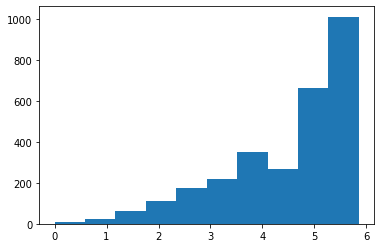

In [251]:
_ = plt.hist(idf)

In [252]:
common_words = all_tokens[idf < 2]
print(common_words.shape)
print(" ".join(common_words))

(133,)
APA MATH NAMED NUMBER PsycINFO VARIABLE abil academ achiev across addit also although among analys analysi assess associ base better c children classroom cognit compar comprehens condit consist control data demonstr design develop differ direct discuss earli educ effect evid examin experi factor find first focus found general grade group high higher howev i.e. identifi implic import improv in includ increas indic individu influenc inform instruct intervent investig knowledg languag learn level low lower mathemat may measur model moder negat one outcom particip perform posit practic predict present problem process provid random read record relat relationship report research reserv result reveal right sampl school score self show signific skill social specif structur student studi suggest support task teacher term test the theori these this time to understand use we well whether work year


In [257]:
specific_words = all_tokens[idf.argsort()[-200:]]
print(" ".join(specific_words))

schoolmat schooler deign scholast scheme schemat delib deliber delic alfonso rout rote diari dichotomi diffus residu resid abov abracadabra reread diploma request reproduct alik disaggreg replet disagr respeto rough respiratori rest rotat root room robert rival richer revisit desktop destruct allen return retrospect retest retali resubsumpt dialog prose effortless proper phone philippin exemplar phen exit phantom pervas expens experienti expert persever perpetr pernici perman perfect exclusionist percentil phonet excit exacerb plural playground platform plant exagger plagu placement placebo pipelin pioneer piecewis piecem excess exchang phonogram pois extrem fabric palestinian pairwis paint painstak pacif felt overwhelm oversampl overrid overreport overconfid overcam outreach outlin outgroup pani extrins fear fastest facto pen peg ahead pedagogi paus pauciti factual patricia faculti paternalist passion fallaci falsif falsifi fatigu agreeabl polit polynomi elucid problemat email probe e

## Clustering
Let's try something simple - represent texts as vector of TF-IDF of all words and then run K-means on it.

In [370]:
from sklearn.cluster import KMeans

k = 4
kmeans = KMeans(n_clusters=k, random_state=26).fit(tfidf)

print(Counter(kmeans.labels_))

Counter({2: 128, 0: 121, 3: 99, 1: 1})


Cluster #1:
    1) Effects of a research-based intervention to improve seventh-grade students’ proportional problem solving: A cluster randomized trial.
    2) Beneficial for some or for everyone? Exploring the effects of an autonomy-supportive intervention in the real-life classroom.
    3) The function of selection of assessment leads evaluators to artificially create the social class achievement gap.
    4) Underpinnings of expectancies of success in mathematics: An analysis of general, school-related, and domain-specific motivation antecedents.
    5) Enhancing physics learning with cognitively activating instruction: A quasi-experimental classroom intervention study.


Cluster #3:
    1) What happens to the fish’s achievement in a little pond? A simultaneous analysis of class-average achievement effects on achievement and academic self-concept.
    2) Self-grading and peer-grading for formative and summative assessments in 3rd through 12th grade classrooms: A meta-analysis.
    3)

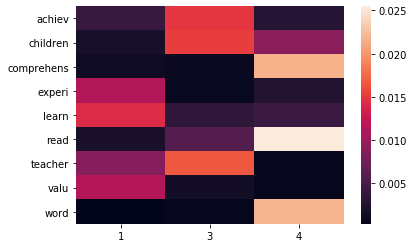

In [388]:
def get_most_typical_texts(kmeans, x, n=1):
    labels = kmeans.predict(x)
    centroid_distances = np.array([
        np.sum(np.square(kmeans.cluster_centers_[labels[i]] - v))
        for i, v in enumerate(x)
    ])
    clusters = [np.where(labels == i)[0] for i in range(kmeans.n_clusters)]
    return {
        i: clusters[i][np.argsort(centroid_distances[clusters[i]])[:n]]
        for i in range(kmeans.n_clusters)
    }

def get_most_important_components(kmeans, n, classes=None):
    return sorted({
        i
        for cls_i, centroid in enumerate(kmeans.cluster_centers_)
        if classes is None or cls_i in classes
        for i in np.argsort(centroid)[-n:]
    })
    

def explain_result(kmeans, x, component_names, top_n_texts=1, top_n_components=3, only_classes=None):
    if only_classes is None:
        only_classes = list(range(k))
    k = kmeans.n_clusters
    most_typical_texts = get_most_typical_texts(kmeans, x, top_n_texts)
    for cls_i in only_classes:
        print(f"Cluster #{cls_i+1}:")
        for i, text_i in enumerate(most_typical_texts[cls_i]):
            title = dataset[text_i][1]
            print(f"    {i+1})", title)
        print("\n")
    
    core_components = get_most_important_components(kmeans, top_n_components, only_classes)
    core_component_names = np.array(component_names)[core_components]
    core_component_values = kmeans.cluster_centers_[:, core_components]
    
    sns.heatmap(
        core_component_values[only_classes, :].T, 
        yticklabels=core_component_names, 
        xticklabels=[str(i+1) for i in only_classes],
        robust=True,
    )
    
    
        
    
explain_result(kmeans, tfidf, all_tokens, 5, only_classes=[0, 2, 3])

Well, not that bad as I expected from so simple method.  
It seems that cluster #1 is about efficient learning for different skills varying from social to mathematical.  
Cluster #2 contains only one text so it seems to be an outlier (and I didn't show explanation for it because it breaks the heatmap readability).  
Cluster #3 represents something about "achievements" - emphasis on words "teacher" and "children" does not seem to me very meaningful...  
And cluster #4 has the most clear semantics - it is dedicated to reading learning in elementary schools.

In [402]:
k = 10
kmeans_k10 = KMeans(n_clusters=k, random_state=37).fit(tfidf)

print(sorted(Counter(kmeans_k10.labels_).values()))

[1, 1, 2, 2, 7, 12, 51, 54, 108, 111]


Cluster #1:
    1) Effects of a strategy-focused instructional program on the writing quality of upper elementary students in the Netherlands.
    2) What happens to the fish’s achievement in a little pond? A simultaneous analysis of class-average achievement effects on achievement and academic self-concept.
    3) Self-grading and peer-grading for formative and summative assessments in 3rd through 12th grade classrooms: A meta-analysis.
    4) Beneficial for some or for everyone? Exploring the effects of an autonomy-supportive intervention in the real-life classroom.


Cluster #2:
    1) Comparing three models of achievement goals: Goal orientations, goal standards, and goal complexes.
    2) Performance-approach goal effects depend on how they are defined: Meta-analytic evidence from multiple educational outcomes.
    3) Longitudinal investigation into the role of perceived social support in adolescents’ academic motivation and achievement.
    4) University instructors’ achievement 

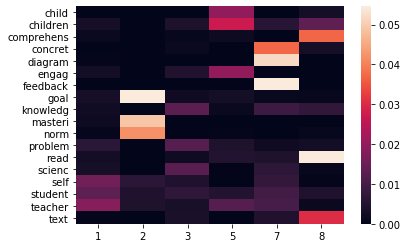

In [406]:
interesting_classes = sorted(cls_i for cls_i, n_texts in Counter(kmeans_k10.labels_).items() if n_texts > 5)
explain_result(kmeans_k10, tfidf, all_tokens, 4, only_classes=interesting_classes)

Cluster #3:
    1) Acquiring science and social studies knowledge in kindergarten through fourth grade: Conceptualization, design, implementation, and efficacy testing of content-area literacy instruction (CALI).
    2) "Conceptual knowledge of fraction arithmetic": Correction to Siegler and Lortie-Forgues (2015).
    3) Conceptual knowledge of fraction arithmetic.
    4) Gender differences and school influences with respect to three indicators of general intelligence: Evidence from Saudi Arabia.
    5) The half empty question for socio-cognitive interventions.
    6) The narrative waltz: The role of flexibility in writing proficiency.
    7) “The narrative waltz: The role of flexibility in writing proficiency”: Correction to Allen, Snow, and McNamara (2016).
    8) Different presentations of a mathematical concept can support learning in complementary ways.
    9) Predicting success on high-stakes math tests from preschool math measures among children from low-income homes.
    10) Di

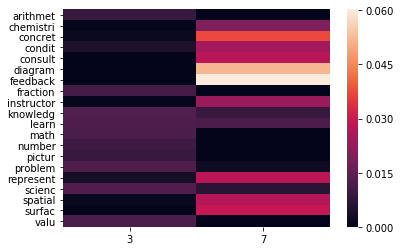

In [411]:
# take a closer look at clusters #3 and #7
explain_result(kmeans_k10, tfidf, all_tokens, 10, 10, only_classes=[2, 6])

Cluster #1: Interesting, it's top-4 articles are the from top-5 of three different clusters ink=4 clusterization.  Looking both at heatmap and top-4 articles I think that semantics of this cluster is unclear. :(  
Cluster #2: All about goals and achievements. So we can found an university for coaches?  
Cluster #3: About nothing. Can't generalize it.  
Cluster #5: Clear one, it is concerned about learning of pre-school and early school children.  
Cluster #7: Seems to be a mix of articles related to feedback from teacher to student and to learning and manipulating models.  
Cluster #8: Is about reading - very similar to claster #4 from k=4 clusterization.  